In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

c:\Users\user\.conda\envs\test\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\user\.conda\envs\test\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\user\.conda\envs\test\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
noise_factor = 0.2
EPOCH = 30
learning_rate = 0.005

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [4]:
x_train_noised = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noised = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noised = tf.clip_by_value(x_train_noised, clip_value_min=0., clip_value_max=1.)
x_test_noised = tf.clip_by_value(x_test_noised, clip_value_min=0., clip_value_max=1.)

In [5]:
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28,28)),
      layers.Reshape((28,28,1)),
      layers.Conv2D(16, kernel_size=2, padding='same'),
      layers.ReLU(),
      layers.MaxPool2D((2,2)),
      layers.Conv2D(32, kernel_size=2, padding='same'),
      layers.ReLU(),
      layers.MaxPool2D((2,2)),
      layers.Reshape((-1,7*7*32)),
      layers.Dense(64, activation='relu'),
      layers.Dense(3)
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(7*7*32, activation='relu'),
      layers.Reshape((7,7,32)),
      layers.Conv2DTranspose(filters = 16, kernel_size=2, strides=2, activation='relu'),
      layers.Conv2DTranspose(filters = 1, kernel_size=2, strides=2, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder()

In [6]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        80        
                                                                 
 re_lu (ReLU)                (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        2080      
                                                                 
 re_lu_1 (ReLU)              (None, 14, 14, 32)        0         
                                                        

In [7]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=losses.MeanSquaredError())

In [8]:
history = autoencoder.fit(x_train_noised, x_train,
                epochs=EPOCH,
                shuffle=True,
                validation_data=(x_test_noised, x_test))

Epoch 1/30
1875/1875 [==============================] - 35s 18ms/step - loss: 0.0310 - val_loss: 0.0252
Epoch 2/30
1875/1875 [==============================] - 46s 24ms/step - loss: 0.0246 - val_loss: 0.0243
Epoch 3/30
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0239 - val_loss: 0.0239
Epoch 4/30
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0235 - val_loss: 0.0234
Epoch 5/30
1875/1875 [==============================] - 44s 23ms/step - loss: 0.0232 - val_loss: 0.0234
Epoch 6/30
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0231 - val_loss: 0.0231
Epoch 7/30
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0229 - val_loss: 0.0232
Epoch 8/30
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0228 - val_loss: 0.0230
Epoch 9/30
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0227 - val_loss: 0.0231
Epoch 10/30
1875/1875 [==============================] - 35s 19m

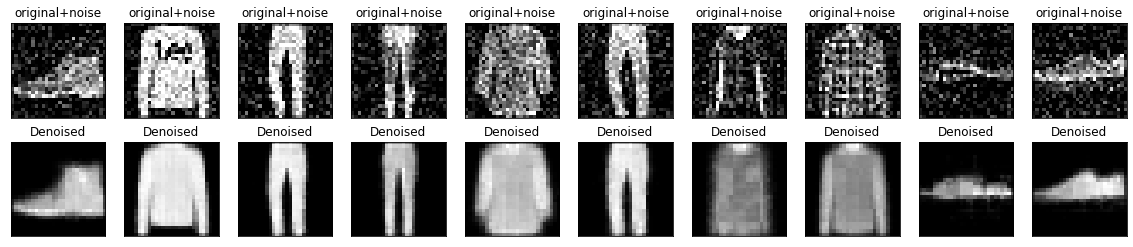

In [9]:
encoded_imgs = autoencoder.encoder(x_test_noised).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test_noised[i])
  plt.title("original+noise")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("Denoised")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [10]:
losses = history.history['loss']
test_losses = history.history['val_loss']

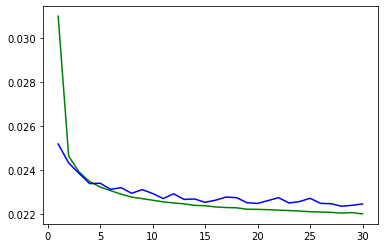

In [11]:
x = range(1, EPOCH+1)
plt.plot(x, losses, 'g', x, test_losses, 'b')
